In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
# The usual notebook preferences

%config InlineBackend.figure_format = 'svg'

import numpy
import sys
import matplotlib.pyplot as plt

sys.path.append('..')
from helper_functions import *

HTML(toggle_code("import functions"))

In [6]:
set_notebook_preferences()

# 3.1 The k-nearest neighbours (kNN) classification algorithm

In this section we will look at the k-nearest neighbour algorithm and how it can be used in relation to the Iris dataset we saw in the [introduction](classification_intro.ipynb).

One simple algorithm is to classify any given point according to the membership of its closest point. That is to say, given an unseen point $\mathbf{x}^*$, we would assign it to the same class as the nearest data point $\mathbf{x}_i$ such that:

$$
i = \arg\min\limits_{n}\big|\big|\mathbf{x}^* - \mathbf{x}_n\big|\big|
$$

There is an important question here which concerns how to define *closest* and in particular how to define *distance*. This issue is more obvious for a high-dimensional case, or a case where inputs have different units $-$ such as a dataset containing heights and weights of animals. In neither case is it clear that the usual Euclidian distance is the most appropriate way to tackle the problem. Some possibilities for our definition of distance are

\begin{align}
~\\
d(\mathbf{x}_1, \mathbf{x}_2) &= \sum_{d} \big|x_{1,d} - x_{2,d}\big|,~\text{sum of absolute values ($L1$ distance)}\\
~\\
d(\mathbf{x}_1, \mathbf{x}_2) &= \bigg[\sum_{d} \big|x_{1,d} - x_{2,d}\big|^2\bigg]^{1/2},~\text{Euclidian distance ($L2$ distance)}\\
~\\
d(\mathbf{x}_1, \mathbf{x}_2) &= \bigg[\sum_{d} \big|x_{1,d} - x_{2,d}\big|^p\bigg]^{1/p},~\text{$p^{th}$ norm  ($Lp$ distance)}\\
\end{align}

**How should we choose the appropriate measure of distance?** We could test the candidate measures and pick the one which performs best on the training set, however for the moment let's stick with $L2$ and address this choice later. It is also worth noting that this method does not require any training: there are no parameters to optimise and the "training" effectively consists of storing the training set to compare with future datapoints $-$ making the algorithm easy to implement:

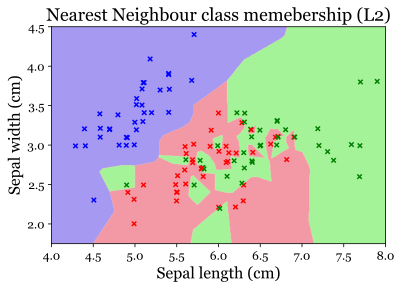

In [7]:
x = np.load('iris_inputs_2d.npy')
y = np.load('iris_labels.npy')

no_train = (x.shape[0] * 3) // 4 # keep 3/4 points in the training and 1/4 in the test sets

x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y[:no_train], y[no_train:] # select training/test points

s_len, s_wid = np.linspace(4, 8, 500), np.linspace(1.75, 4.5, 500) # sepal lengths/widths to evaluate class membership

grid = np.stack(np.meshgrid(s_len, s_wid), axis = -1) # stack into (500, 500, 2) array to do arithmetic

cloned_grid = np.stack([grid] * no_train, axis = -2) # copy grid no_train times into a (500, 500, no_train, 2) array


# the whole algorithm is contained in these 3 lines
distances = np.sum((cloned_grid - x_train)**2, axis = -1) # compute L2 to get a (500, 500, no_train) array

idx = np.argmin(distances, axis = -1).reshape((-1,)) # find closest point to each training point, then flatten

classes = y_train[idx].reshape(500, 500) # classify each grid point according to the closest training point


plt.contourf(s_len, s_wid, classes, cmap = 'brg', alpha = 0.4) # plot membership areas
plt.scatter(x_train[:, 0], x_train[:, 1], marker = 'x', s = 20, color = np.array(['b', 'r', 'g'])[y_train]) # plot data
beautify_plot({"title":"Nearest Neighbour class memebership (L2)", "x":"Sepal length (cm)", "y":"Sepal width (cm)"})
plt.show()

HTML(toggle_code())

The borders between the classes in such a graph are refered to as **decision boundaries** or **decision surfaces**. The blue class is well separated from the red and green classes resulting in the large chunk of blue with one continuous decision boundary. However, the red and blue crosses are more intermixed, resulting in small islands of red membership in the green region and vice versa, which are caused by individual points. Having these small islands may or may not be reasonable, and we will shortly address this point. Before that, let's evaluate the algorithm's performance. **What should the accuracy of a random classification algorithm be?** Let's evaluate the test set accuracy:

In [8]:
x_test_clone = np.stack([x_test] * no_train, axis = -2) # clone test points into (no_test, no_train, 2) array

distances_test = np.sum((x_test_clone - x_train) ** 2, axis = -1) # compute L2 distances as before

idx = np.argmin(distances_test, axis = -1) # find closest point to each training point ()

classes_test = y_train[idx] # classify training points

accuracy = (classes_test == y_test).mean() * 100 # calculate classification accuracy
print("Classification accuracy on test set of {} points = {}%".format(y_test.shape[0], accuracy.round(2)))

Classification accuracy on test set of 38 points = 78.95%


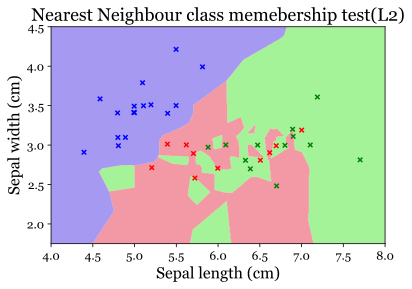

In [9]:
# plot class the memebrships and the test points
plt.contourf(s_len, s_wid, classes, cmap = 'brg', alpha = 0.4)
plt.scatter(x_test[:, 0], x_test[:, 1], marker = 'x', s = 20, color = np.array(['b', 'r', 'g'])[y_test])
beautify_plot({"title":"Nearest Neighbour class memebership test(L2)", "x":"Sepal length (cm)", "y":"Sepal width (cm)"})
plt.show()

HTML(toggle_code())

A variation on this algorithm, that may produce smoother decision boundaries that account for the class overlap that is to be expected from such measurements, is to instead look at the $k$ nearest neighbours for each unseen point  $\mathbf{x}^*$ for some value $k > 0$. We do this by **choosing the most commonly occuring class among the $k$ nearest neighbours**, and using this as our estimate for the class of $\mathbf{x}^*$. In the event that there are 2 or more classes with the most occurences, we choose randomly among these classes. This is known as the **k-nearest neighbour algorithm**.

In [10]:
def kNN(X_train, Y_train, X_test, k, p = 2):
    
    X_test_clone = np.stack([X_test] * X_train.shape[0], axis = -2) # clone test points for comparisons as before
    
    distances = np.sum(np.abs(X_test_clone - X_train) ** p, axis = -1) # compute Lp distances
    
    idx = np.argsort(distances, axis = -1)[:, :k] # find k smallest distances
    
    classes = y_train[idx] # classes corresponding to the k smallest distances
    
    predictions = []
    
    for class_ in classes:
        
        uniques, counts = np.unique(class_, return_counts = True) # getting the set of classes, and counting the occurences
        
        if (counts == counts.max()).sum() == 1: # checking if there is a unique class with the most occurences in the kNN
            
            predictions.append(uniques[np.argmax(counts)]) # adding the class with the most occurences to predictions
            
        else:
            
            # if multiple classes have the maximum occurences in the kNN, choose randomly among them
            
            predictions.append(np.random.choice(uniques[np.where(counts == counts.max())[0]])) 
            
            
    return np.array(predictions) # return the predictions

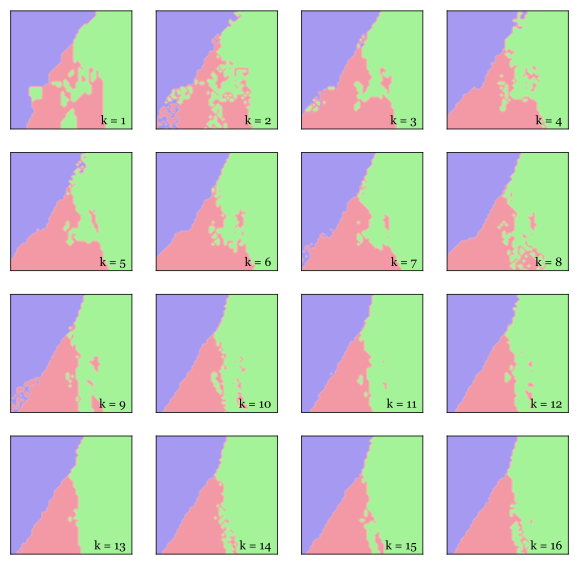

In [11]:
no_train = (x.shape[0] * 3) // 4 # keep 3/4 points in the training and 1/4 in the test sets

x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y[:no_train], y[no_train:] # select training/test points

s_len, s_wid = np.linspace(4, 8, 50), np.linspace(1.75, 4.5, 50) # sepal lengths/widths to evaluate class membership

grid = np.stack(np.meshgrid(s_len, s_wid), axis = -1) # stack into (500, 500, 2) array to do arithmetic

flat_grid = grid.reshape((-1, x_train.shape[1])) # 

plt.figure(figsize  = (10, 10))

for k in range(1,17):

    classes = kNN(x_train, y_train, flat_grid, k, p = 2) # call the kNN function to get the classes of the points

    plt.subplot(4, 4, k)
    plt.contourf(s_len, s_wid, classes.reshape(grid.shape[:-1]), cmap = 'brg', alpha = 0.4) # plot membership areas
    plt.text(7.8, 1.8, s = 'k = ' + str(k), color = 'black', fontsize = 12,
                 horizontalalignment = 'right', verticalalignment = 'bottom')
    remove_axes()

plt.show()

HTML(toggle_code())

Here we can  see how the graphs tend towards smoother boundaries for higher values of $k$. However, **is a larger value of $k$ always preferable to a smaller one?** Would it not be possible to over smooth and lose some of the nuance in the decision boundaries? This raises the question of how to choose $k$, and how to test for which value of $k$ will be most likely to lead to a higher classification accuracy in testing, without observing the test data. 

One approach to choosing $k$ is to take a small portion of your training set and use this as what is known as a **validation set**. We use the remainder of the training set as before, and then test the classification accuracy of the model on the validation set, and use this as a measure of how optimal our choice of $k$ is. By doing this, we can iterate over different values of $k$ and choose the value with the best accuracy on the validation set. 

This approach can be problematic, however, if there is insufficient data to use a large validation set and still have enough training data. To avoid this we can employ a method known as **n-fold cross-validation** which involves splitting the training data into n folds (or sections), and performing validation for each of these folds as your validation set, and using the mean of the accuracies accross these different validation sets as your measure of optimality for each value of $k$.

$$
$$

<div>
    <img src="validation_set.GIF" alt="Snow" style="width:90%; float: center;">
</div>

Now lets apply this method to the iris dataset, to see if it helps find an optimal value of $k$. In the below figure, we plot mean accuracy $\pm$ the standard deviation, accross each validation set, for each value of $k$ in a given range. For clarity we have used the full 4D iris dataset, as this gives a clearer demonstration of validation sets. Try varying the number of folds, or the values of k to test accross (bear in mind $0 < k < 150$ by definition, as there are 150 datapoints) and see how the graph changes.

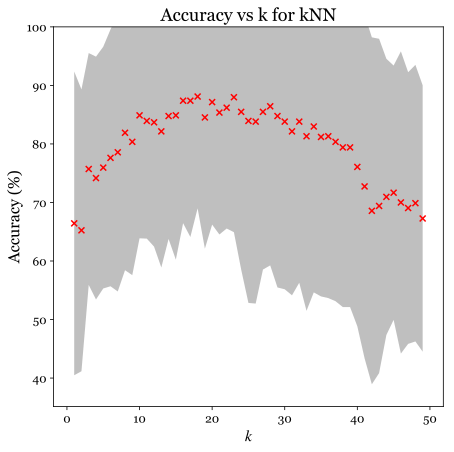

In [12]:
no_folds = 15

k_max = 50

x = np.load('iris_inputs_full.npy')
y = np.load('iris_labels.npy')

no_train = (x.shape[0] * 3) // 4 # keep 3/4 points in the training and 1/4 in the test sets

x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y[:no_train], y[no_train:] # select training/test points

plt.figure(figsize  = (7, 7))

means, stdevs = np.zeros((2, k_max - 1))

for k in range(1, k_max):
    
    accuracies = np.zeros((no_folds,))
    
    for v in range(no_folds):
        
        x_folds, y_folds = np.array_split(x_train, no_folds), np.array_split(y_train, no_folds)
        
        x_validation, y_validation = x_folds.pop(v), y_folds.pop(v)
        
        x_train_rem, y_train_rem = np.concatenate(x_folds), np.concatenate(y_folds)

        classes = kNN(x_train_rem, y_train_rem, x_validation, k, p = 2) # call the kNN function to get the classes of the points
        
        accuracies[v] = (classes == y_validation).mean() * 100
    
    means[k-1] = accuracies.mean()
    
    stdevs[k-1] = accuracies.var() ** 0.5

plt.fill_between(np.arange(1,50), means + stdevs, means - stdevs, facecolor = 'grey', alpha = 0.5)
plt.scatter(np.arange(1,50), means, marker = 'x', color = 'red')
beautify_plot({"title":"Accuracy vs k for kNN", "x":"$k$", "y":"Accuracy (%)"})
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,100))
plt.show()

HTML(toggle_code())

It is worth noting that the same approach can be used to decide the value of $p$ from the distance equations, for datasets with more dimensions, although for the iris dataset the value of p does not affect the accuracy hugely.

As we have shown, the kNN algorithm can be effective in certain settings, including classifying low dimensional data. There are, however, several major drawbacks of this algorithm. For instance, whilst it does not require any time to train, it can be very **computationally expensive to store and perform computation on the entire training set**, especially for large data sets. This is unsatisfactory and in practice we often prefer models that are expensive to train but cheap to use to classify new data points over models that are the reverse. Another major drawback of kNN is that it **only accounts for hard (discrete) decision boundaries and doesn't tell us anything about the uncertainty**. This can be costly in situations where uncertainty is important, such as classifying an image of a tumour as either malignant or benign. Here the goal is not simply to be correct as often as possible, but also to minimize repurcussions in cases where the model is incorrect. This can be done with soft decision boundaries, in which the the output is not a 1-of-k encoding, but a probability for each of the possible classes. 

## Comparing and contrasting k-nearest neighbours to logistic classification

The model based approach will ... [nearest neighbours](classification_kNN.ipynb) computational cost in higher dimesions, soft classification ?



Having covered the k-nearest neighbours algorithm, you should now understand:
    
1. The nearest neighbour algorithm (and note that this is a special case of the kNN algorithm where $k = 1$)
2. The meaning of the $Lp$ distance between two points, and why the Euclidean distance ($L2$) is not always the best measure of distance
3. The k-nearest neighbour algorithm, and why it can outperform the nearest neighbour approach
4. How validation and n-fold cross-validation can be used to determine the optimal values for parameters 
5. The limitations of the k-nearest neighbours algorithm

In [section 3.2](classification_logistic_regression.ipynb). we will look at models that work with soft as opposed to hard decision boundaries.

### Questions

1. Devise a k nearest neighbours approach to classification. 